## Simple example using pykegg

### Overlay on the raw KEGG image

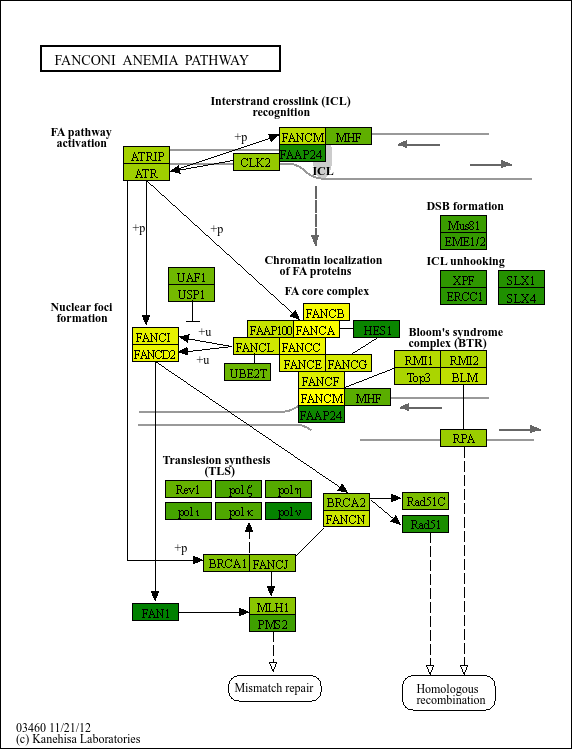

In [9]:
import requests_cache
import pandas as pd
import numpy as np
from PIL import Image
import pykegg
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

## Make sure to cache all the downloaded files to avoid recursive connection
requests_cache.install_cache('pykegg_cache')
graph = pykegg.KGML_graph(pid="hsa03460")

## Overlay to raw image
nds = graph.get_nodes()

## Assign random color
nds = nds[nds.original_type=="gene"]
nds["lfc"] = np.arange(-2,2,0.01)[0:nds.shape[0]]
cmap_grad = mpl.colors.LinearSegmentedColormap.from_list("cmap_grad", ["yellow","green"])
norm = mpl.colors.Normalize(vmin=min(nds.lfc), vmax=max(nds.lfc))
nds["color"] = [
        mpl.colors.to_hex(cmap_grad(norm(x))) if x is not None else None
        for x in nds.lfc
    ]
Image.fromarray(pykegg.overlay_opencv_image(nds, pid="hsa03460"))

### Convert to `igraph` and analyze
We plot here edges and nodes, where gene and group nodes were differently colored by `plotnine`. The node and text size implicates degree. Here, we do not consider the multiple edge attributes.

In [10]:
## Export as igraph
g = graph.get_graph(layout="kk")
print(g)

nodes = graph.get_nodes()
nodes["x"] = [i["x"] for i in g.vs]
nodes["y"] = [i["y"] for i in g.vs]
nodes["deg"] = g.degree(g.vs)
nodes["graphics_name_sp"] = nodes.graphics_name.apply(lambda x: x.split(",")[0])
subset_nodes = nodes[nodes.deg>0]

IGRAPH DN-T 58 22 --
+ attr: bgcolor (v), coords (v), fgcolor (v), graphics_name (v), group (v),
  height (v), id (v), name (v), orig_id (v), original_type (v), pathway_name
  (v), type (v), width (v), x (v), xmax (v), xmin (v), y (v), ymax (v), ymin
  (v), entry1_orig_id (e), entry2_orig_id (e), reaction (e), subtypes (e),
  type (e)
+ edges (vertex names):
undefined->hsa:2177, undefined->hsa:55215, undefined->hsa:2175,
undefined->hsa:55215, undefined->hsa:57697, undefined->hsa:5889,
hsa:91442->hsa:9894, hsa:9894->hsa:545, undefined->hsa:57697,
hsa:22909->undefined, hsa:2177->hsa:675, hsa:57697->hsa:91442,
undefined->hsa:29935 hsa:6117 hsa:6118 hsa:6119, hsa:57697->hsa:100526739
hsa:201254 hsa:378708, hsa:675->hsa:5888, hsa:83990->undefined,
hsa:2177->hsa:22909, undefined->hsa:55120, hsa:83990->undefined,
undefined->hsa:2189, hsa:545->hsa:672, undefined->hsa:57697


In [11]:
edges = pykegg.return_segments(graph, subset_nodes)
edges = edges.apply(lambda x: pykegg.shorten_end(x, 0.7), axis=1)
edges["subtype"] = edges.subtypes.apply(lambda x: x[0][0])

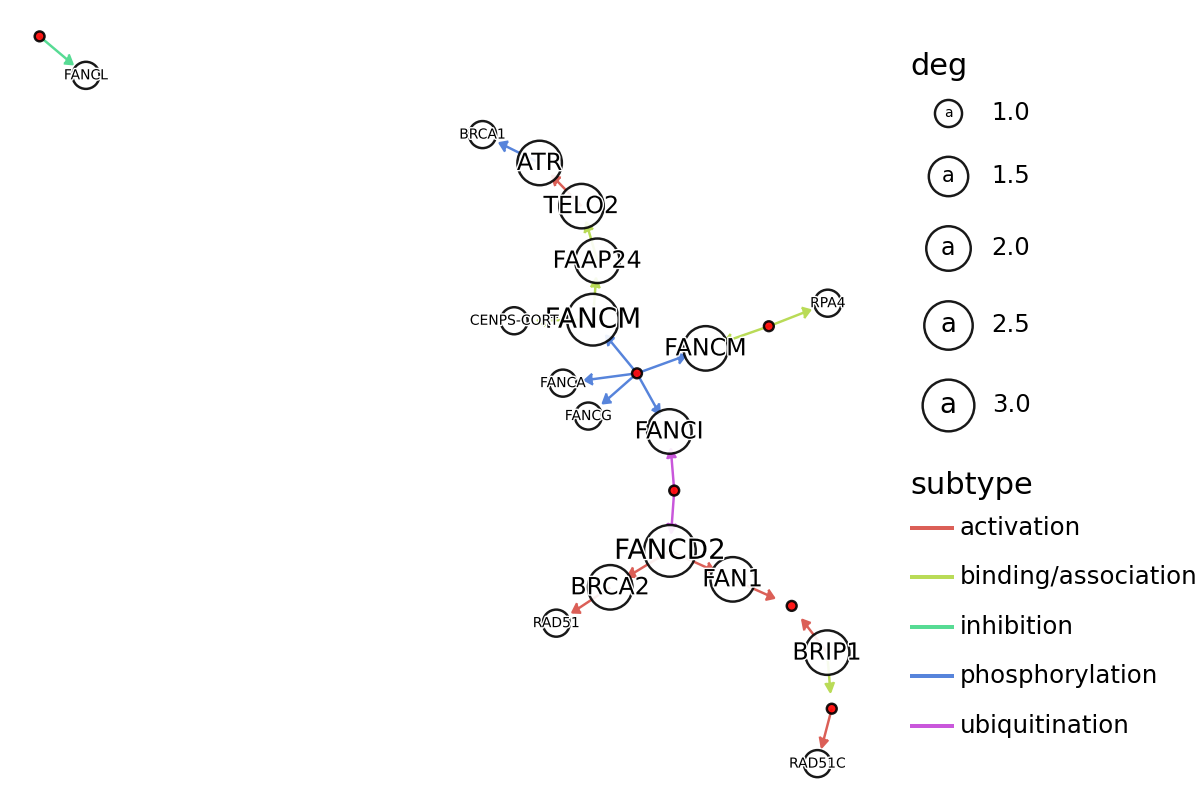

In [12]:
import matplotlib.patheffects as path_effects
from plotnine import (
    ggplot,
    options,
    geom_point,
    geoms,
    aes,
    geom_segment,
    theme_void,
    geom_rect,
    geom_text,
    scale_size
)
options.figure_size = (6, 4)

(
        ggplot()
         + geom_segment(
            aes(x="x", y="y", xend="xend", yend="yend", color="subtype"), data=edges,
            arrow=geoms.arrow(type="closed", length=0.05)
         )
        + geom_point(
            aes(x="x",y="y",size="deg"),
            data=subset_nodes[subset_nodes.original_type == "gene"],
            color="black", alpha=0.9, fill="#ffffff"
            )
            + geom_point(
            aes(x="x",y="y"),
            data=subset_nodes[subset_nodes.original_type == "group"],
            color="black", alpha=0.9, fill="#ff0000"
            )
           +geom_text(
             aes(x="x",y="y", label="graphics_name_sp", size="deg"),
               family="sans", 
            data=subset_nodes[subset_nodes.original_type == "gene"],
            color="black", path_effects=[path_effects.Stroke(linewidth=1, foreground='white'),
                       path_effects.Normal()]
           )+
    scale_size([5,10])+
    theme_void()

)

### Plot using plotnine

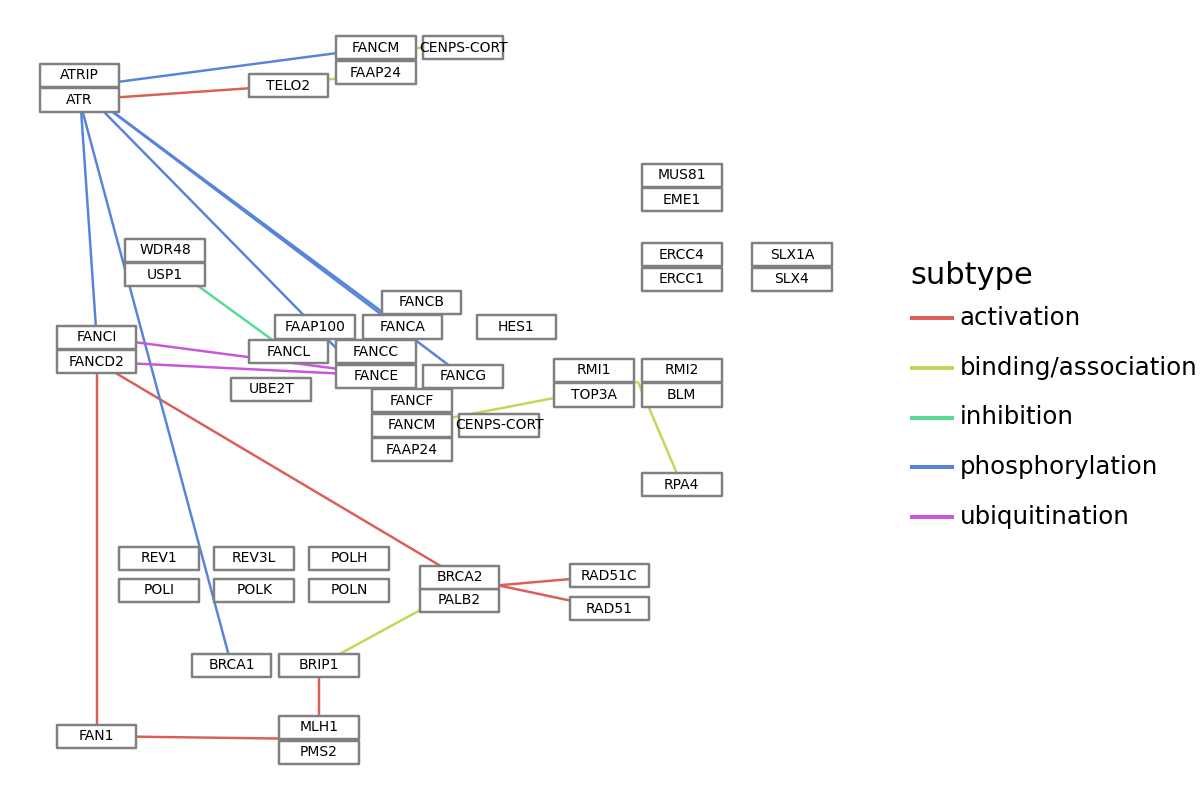

In [19]:
## Some parameters
node_x_nudge=25
node_y_nudge=25
label_size=5
split_graphics_name=","
show_label="gene"
subtype_num=0
edge_color="subtype"
text_label="graphics_name"

node_df = graph.get_nodes(node_x_nudge=node_x_nudge, node_y_nudge=node_y_nudge)
edge_df = graph.get_edges()
if split_graphics_name:
    node_df["graphics_name"] = node_df.graphics_name.apply(
        lambda x: x.split(",")[0]
    )

## Collapse subtypes
edge_df_col = []
for i in edge_df.index:
    tmp = edge_df.iloc[i, :]
    for subtype in tmp.subtypes:
        edge_df_col.append(
            [tmp.entry1, tmp.entry2, tmp.type, subtype, tmp.reaction]
        )
edge_df = pd.DataFrame(edge_df_col)
edge_df.columns = ["entry1", "entry2", "type", "subtypes", "reaction"]
seg_df = pd.concat(
    [
        node_df.reset_index()
        .set_index("id")
        .loc[edge_df.entry1]
        .reset_index()
        .loc[:, ["x", "y"]],
        node_df.reset_index()
        .set_index("id")
        .loc[edge_df.entry2]
        .reset_index()
        .loc[:, ["x", "y"]],
    ],
    axis=1,
)
seg_df.columns = ["x", "y", "xend", "yend"]
seg_df = pd.concat([seg_df, edge_df], axis=1)

seg_df["subtype"] = seg_df.subtypes.apply(
    lambda x: x[subtype_num] if x is not None else x
)

plot = (
    ggplot()
    + geom_segment(
        aes(x="x", y="y", xend="xend", yend="yend", color=edge_color), data=seg_df
    )
    + geom_rect(
        aes(xmin="xmin", ymin="ymin", xmax="xmax", ymax="ymax"),
        data=node_df[node_df.original_type == "gene"],
        fill="white",
        color="grey",
    )
    + geom_rect(
        aes(xmin="xmin", ymin="ymin", xmax="xmax", ymax="ymax"),
        data=node_df[node_df.original_type == "compound"],
        fill="white",
        color="grey",
    )
    + geom_text(
        aes(x="x", y="y", label=text_label, filter="original_type!='group'"),
        data=node_df[node_df.original_type == show_label],
        size=label_size,
    )
    + theme_void()
)

plot

### Customization of nodes and edges
In `plot_kegg_pathway_plotnine`, various geoms are used to plot KEGG PATHWAY information.
Users would like to customize the visualization such as using arrows for directed relationships.
Some functions are prepared for this purpose, outlined below.

In [20]:
graph = pykegg.KGML_graph(pid="hsa04110") ## Cell cycle
options.figure_size = (12, 9) ## Change plotnine plot size
node_df = graph.get_nodes(node_x_nudge=20, node_y_nudge=10) ## Change the node size
seg_df = pykegg.return_segments(graph) ## return edge data frame for the use in `geom_segment`
seg_df2 = seg_df.apply(lambda x: pykegg.shorten_end(x, 0.8), axis=1) ## shorten end of edges for visualization of arrow
hsa = pykegg.id_to_name_dict("hsa") ## Obtain dict for converting hsa* IDs
node_df["converted"] = node_df["name"].apply(lambda x: pykegg.convert_id(x, hsa)) ## Convert ID

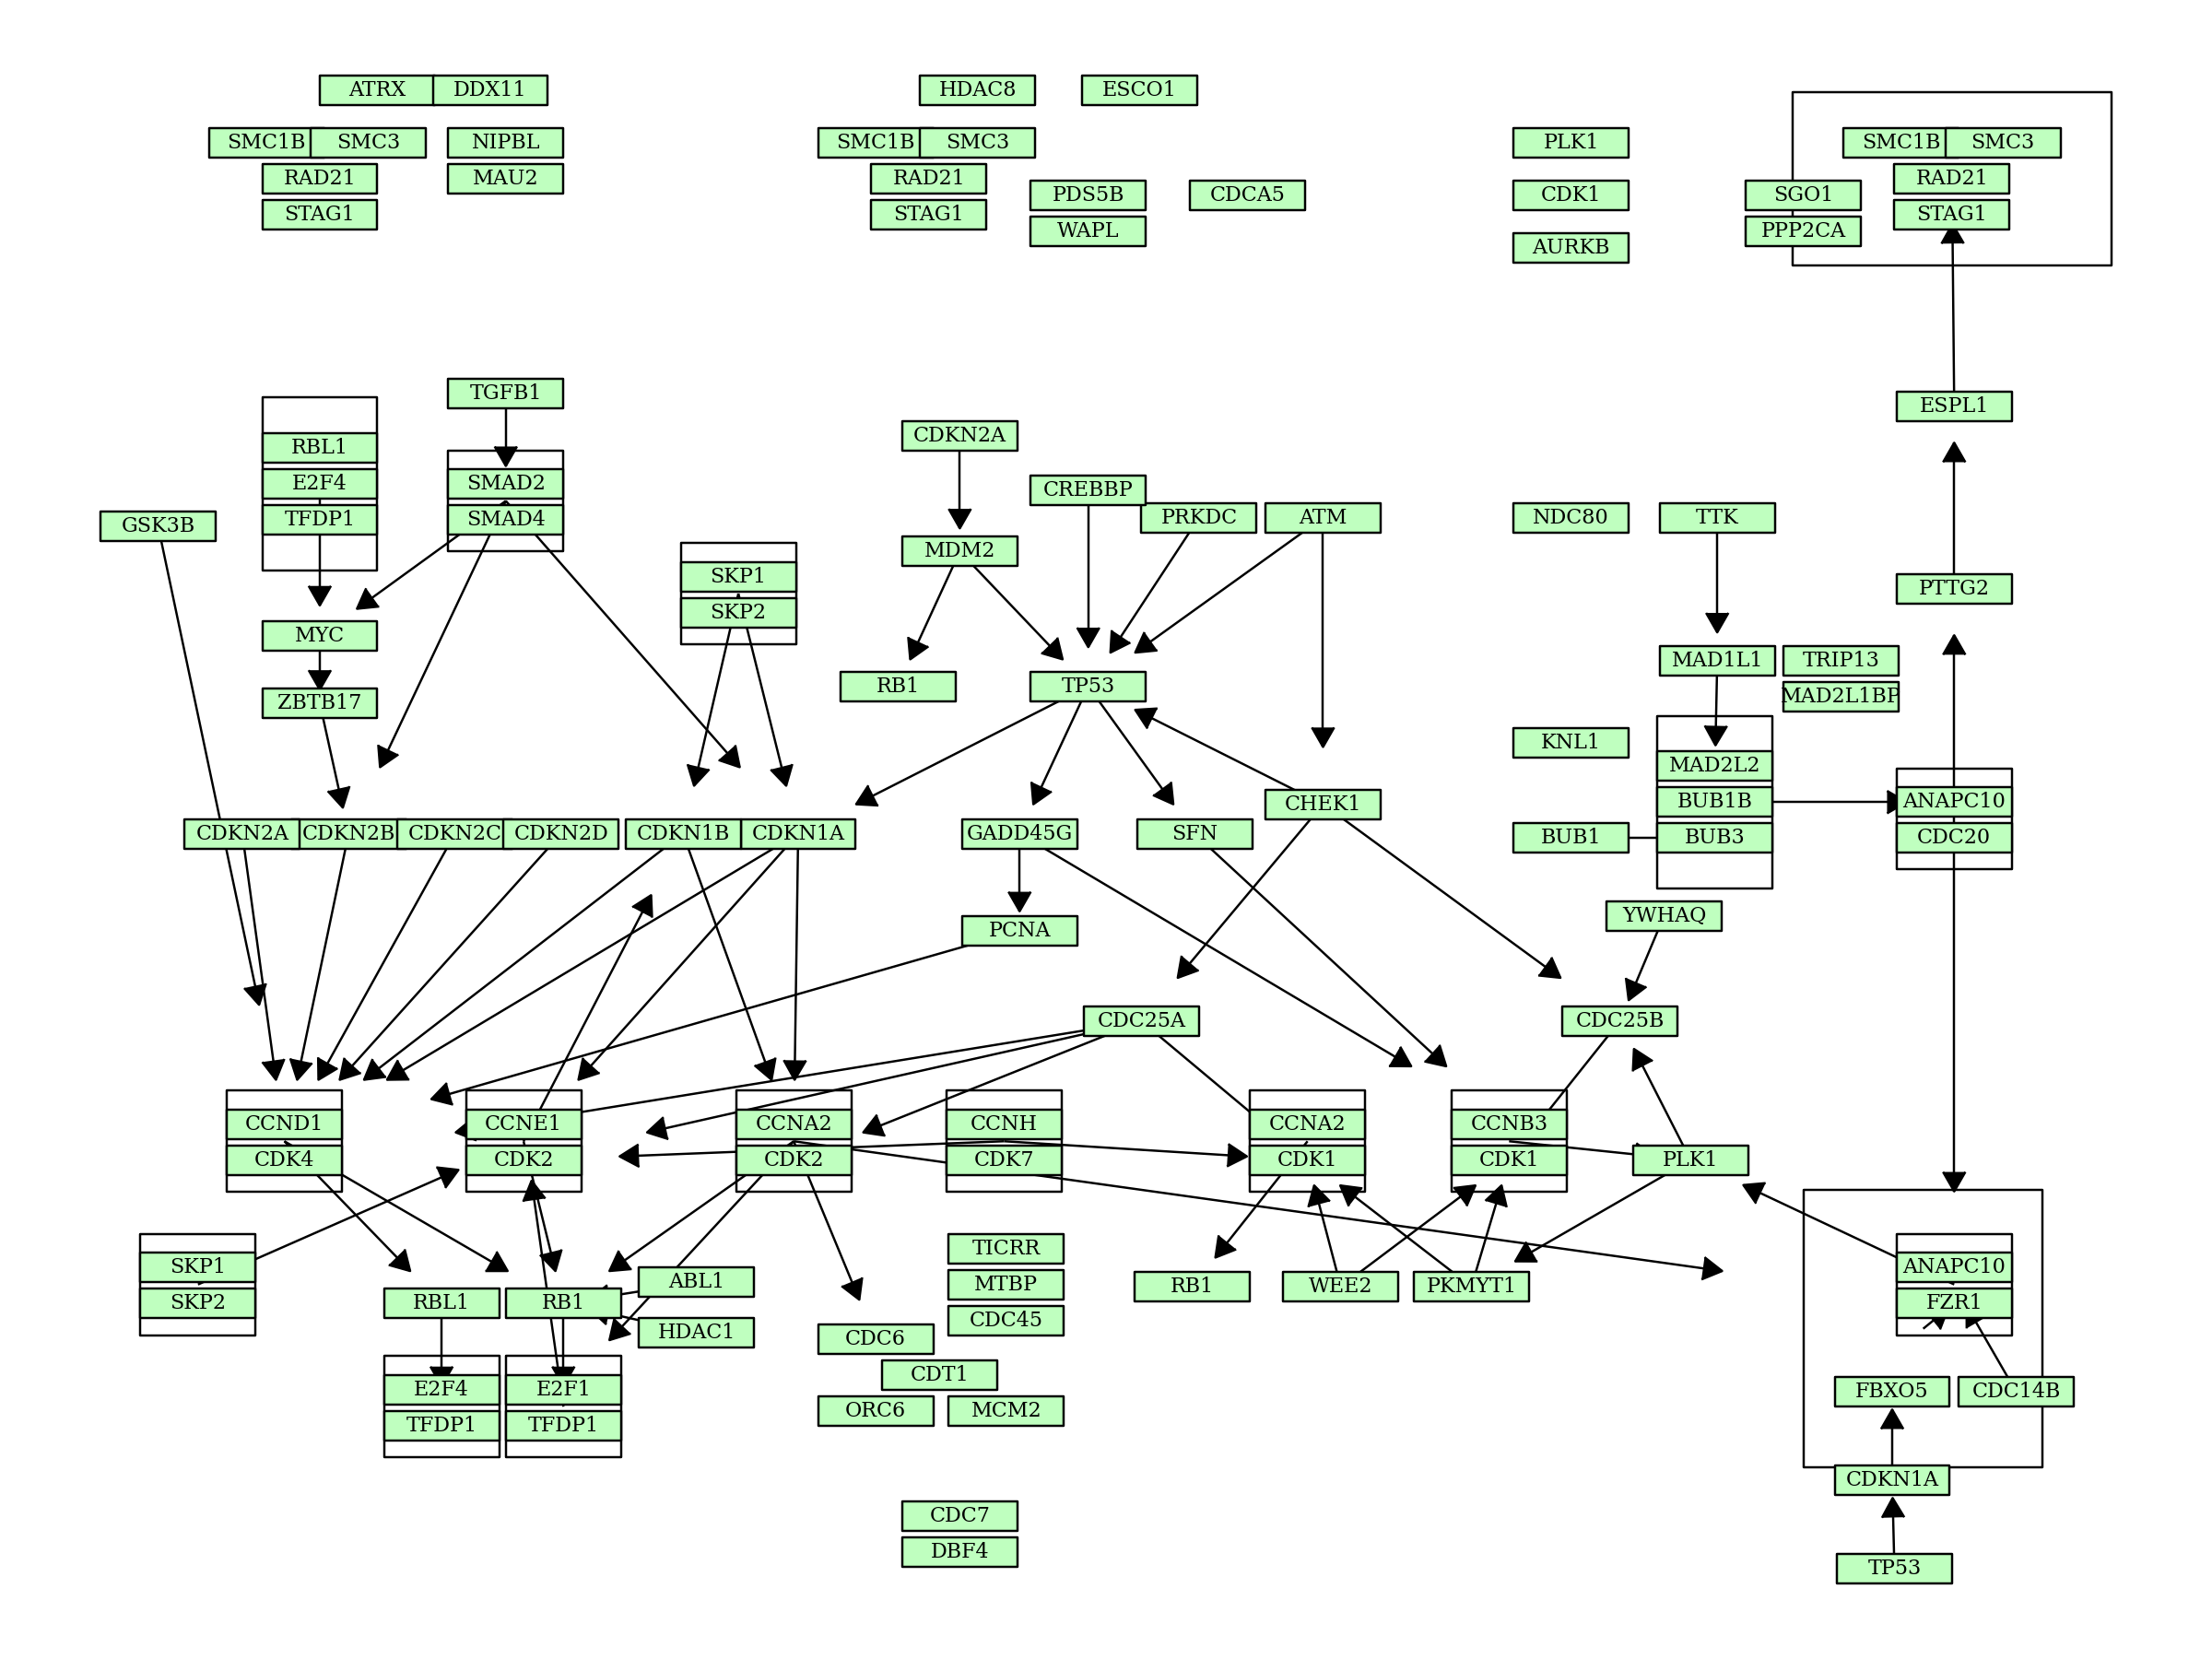

In [21]:
(
        ggplot()
         + geom_segment(
            aes(x="x", y="y", xend="xend", yend="yend"), data=seg_df2,
            arrow=geoms.arrow(type="closed", length=0.05)
         )
        + geom_rect(
            aes(xmin="xmin", ymin="ymin", xmax="xmax", ymax="ymax"),
            data=node_df[node_df.original_type == "group"],
            color="black", alpha=0, fill="#ffffff"
            )
        + geom_rect(
            aes(xmin="xmin", ymin="ymin", xmax="xmax", ymax="ymax"),
            data=node_df[node_df.original_type == "gene"],
            color="black",
            fill=node_df[node_df.original_type == "gene"].bgcolor)
           +geom_text(
             aes(x="x",y="y", label="converted"),
               family="serif", size=8,
            data=node_df[node_df.original_type == "gene"],
            color="black"       
           )+
    theme_void()
 
    
)